In [ ]:
from math import floor
import numpy as np

def row_col_to_seq(row_col, num_cols):  #Converts state number to row_column format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.max_steps=100
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind
        self.steps=0

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
      self.done = False
      self.steps = 0
      return int(self.start_state_seq)

    def step(self, state, action):
        self.steps+=1
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):
            p += self.P[state, next_state, action]
            if r <= p:
                break
        if self.steps >= self.max_steps:
          self.done = True
        if(self.wind and np.random.random() < 0.4):
          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          reward = self.R[next_next]
        else:
          reward = self.R[next_state]
        done = True if reward == self.r_goal or reward == self.r_dead else False
        return next_state, reward, done


In [ ]:
# specify world parameters
num_cols = 10
num_rows = 10
obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                         [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                         [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                         [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
restart_states = np.array([[3,7],[8,2]])
start_state = np.array([[3,6]])
goal_states = np.array([[0,9],[2,2],[8,7]])

# create model
gw = GridWorld(num_rows=num_rows,
               num_cols=num_cols,
               start_state=start_state,
               goal_states=goal_states, wind = False)
gw.add_obstructions(obstructed_states=obstructions,
                    bad_states=bad_states,
                    restart_states=restart_states)
gw.add_rewards(step_reward=-1,
               goal_reward=10,
               bad_state_reward=-6,
               restart_state_reward=-100)
gw.add_transition_probability(p_good_transition=0.7,
                              bias=0.5)
env = gw.create_gridworld()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def render_grid(grid_world):
    grid = np.zeros((grid_world.num_rows, grid_world.num_cols))

    start_state = grid_world.start_state.flatten()
    grid[start_state[0], start_state[1]] = 1

    for goal_state in grid_world.goal_states:
        goal_state = goal_state.flatten()
        grid[goal_state[0], goal_state[1]] = 2

    if grid_world.restart_states is not None:
        for restart_state in grid_world.restart_states:
            restart_state = restart_state.flatten()
            grid[restart_state[0], restart_state[1]] = 3

    if grid_world.obs_states is not None:
        for obs_state in grid_world.obs_states:
            obs_state = obs_state.flatten()
            grid[obs_state[0], obs_state[1]] = 4

    if grid_world.bad_states is not None:
        for bad_state in grid_world.bad_states:
            bad_state = bad_state.flatten()
            grid[bad_state[0], bad_state[1]] = 5

    cmap = ListedColormap(['white', 'blue', 'green', 'red', 'black', 'purple'])

    plt.imshow(grid, cmap=cmap, origin='lower')
    plt.title('Grid World')


    legend_labels = ['Start', 'Goal', 'Restart', 'Obstructed', 'Bad']
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10)
                        for color, label in zip(['blue', 'green', 'red', 'black', 'purple'], legend_labels)]
    plt.legend(handles=legend_elements, loc='upper left')

    plt.show()


In [ ]:
print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
print("Number of states", env.num_states)
print("start state", env.start_state_seq)
print("goal state(s)", env.goal_states_seq)

Number of actions 4
Number of states 100
start state [36]
goal state(s) [ 9 22 87]


In [ ]:
env.P[0,:,0]

array([0.85, 0.15, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ])

# Defining Softmax and Epsilon Policy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
%matplotlib inline
from scipy.special import softmax
import numpy as np
seed = 42
rg = np.random.RandomState(seed)

def choose_action_epsilon(Q, state, epsilon, rg=rg):
    if not Q[state[0], state[1]].any(): # TODO: eps greedy condition
        return rg.randint(0,4)# TODO: return random action
    else:
      if rg.random()<epsilon :
        return rg.randint(0,4)# TODO: return best action
      else:
        return np.argmax(Q[state[0], state[1]])

# Q Plot

In [ ]:
def plot_Q(Q, message = "Q plot"):

    plt.figure(figsize=(10,10))
    plt.title(message)
    plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
    plt.colorbar()
    def x_direct(a):
        if a in [0, 1]:
            return 0
        return 1 if a == 3 else -1
    def y_direct(a):
        if a in [3, 2]:
            return 0
        return 1 if a == 0 else -1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    plt.show()


# **Task 1:** Implementing **SAARSA** and **Q-Learning** Algorithems

In [ ]:
# initialize Q-value
Q = np.zeros((env.num_rows, env.num_cols, 4))


episodes = 5000

print_freq = 100

## **SARSA** *Funtion* with `Epsilon Policy`



In [ ]:
def sarsa(env, Q, gamma = 0.9,alpha=0.4, epsilon=0.1, plot_heat = False, choose_action = choose_action_epsilon):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)

    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        st=env.reset()
        state = seq_to_col_row(st,num_cols)[0]


        done = False
        action = choose_action(Q, state, epsilon)

        k=0
        while not done:
            state_next, reward, done = env.step(st,action)

            state_next=str(state_next)
            if len(state_next)>1:
              state_next=[int(state_next[0]),int(state_next[1])]
            else:
              state_next=[0,int(state_next)]
            action_next = choose_action(Q,state_next ,epsilon)

            # TODO: update equation
            Q[state[0],state[1],action]=Q[state[0],state[1],action]+alpha*(reward+gamma*Q[state_next[0],state_next[1],action_next]-Q[state[0],state[1],action])

            tot_reward += reward
            steps += 1

            state, action = state_next, action_next
            st=int(str(state[0])+str(state[1]))
            if steps>=100:

              done=True

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                            Q.max(), Q.min()))

    return Q, episode_rewards, steps_to_completion


In [ ]:
# Q, rewards, steps = sarsa(env, Q, gamma = gamma,alpha=alpha0,epsilon=epsilon0, plot_heat=True, choose_action= choose_action_epsilon)

## **Q-Learning** Function with `Epsilon Policy`

In [ ]:
def qlearning(env, Q, gamma=0.9, alpha=0.4,epsilon=0.1, plot_heat=False, choose_action=choose_action_epsilon):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)

    if plot_heat:
        clear_output(wait=True)
        plot_Q(Q)



    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        st = env.reset()
        state = seq_to_col_row(st, num_cols)[0]

        done = False
        action = choose_action(Q, state, epsilon)

        k = 0
        while not done:
            state_next, reward, done = env.step(st, action)

            state_next = str(state_next)
            if len(state_next) > 1:
                state_next = [int(state_next[0]), int(state_next[1])]
            else:
                state_next = [0, int(state_next)]

            # Q-Learning Update Equation
            Q[state[0], state[1], action] += alpha * (reward + gamma * np.max(Q[state_next[0], state_next[1]]) - Q[state[0], state[1], action])

            tot_reward += reward
            steps += 1

            state, action = state_next, choose_action(Q, state_next, epsilon)
            st = int(str(state[0]) + str(state[1]))

            if steps >= 100:
                done = True

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep + 1) % print_freq == 0 and plot_heat:
            clear_output(wait=True)
            plot_Q(Q, message="Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f" % (
                ep + 1, np.mean(episode_rewards[ep - print_freq + 1:ep]),
                np.mean(steps_to_completion[ep - print_freq + 1:ep]),
                Q.max(), Q.min()))

    return Q, episode_rewards, steps_to_completion


In [ ]:
# Q_qlearning, rewards_qlearning, steps_qlearning = qlearning(env, Q, gamma=gamma,alpha=alpha0, epsilon=epsilon0,plot_heat=True, choose_action=choose_action_epsilon)

# Task 3: Determine the **best set of hyperparameters**

## **Objective Function**

In [ ]:
def run_experiment_and_get_metric(env, learning_function, start_state, wind, alpha, gamma, epsilon,p_good_transition):
    env.wind = wind
    start_state = np.array([start_state])
    env.start_state=start_state
    if wind:
        env.add_transition_probability(p_good_transition=1.0, bias=0.5)
    else:
        env.add_transition_probability(p_good_transition=p_good_transition, bias=0.5)
    Q = np.zeros((env.num_rows, env.num_cols, 4))
    if learning_function == 'sarsa':
        Q_result, rewards, steps = sarsa(env, Q.copy(), gamma=gamma,alpha=alpha,epsilon=epsilon, plot_heat=True, choose_action=choose_action_epsilon)
    elif learning_function == 'qlearning':
        Q_result, rewards, steps = qlearning(env, Q.copy(), gamma=gamma,alpha=alpha,epsilon=epsilon, plot_heat=True, choose_action=choose_action_epsilon)
    else:
        raise ValueError("Invalid learning function")
    return np.sum(rewards)


## **Grid Search**

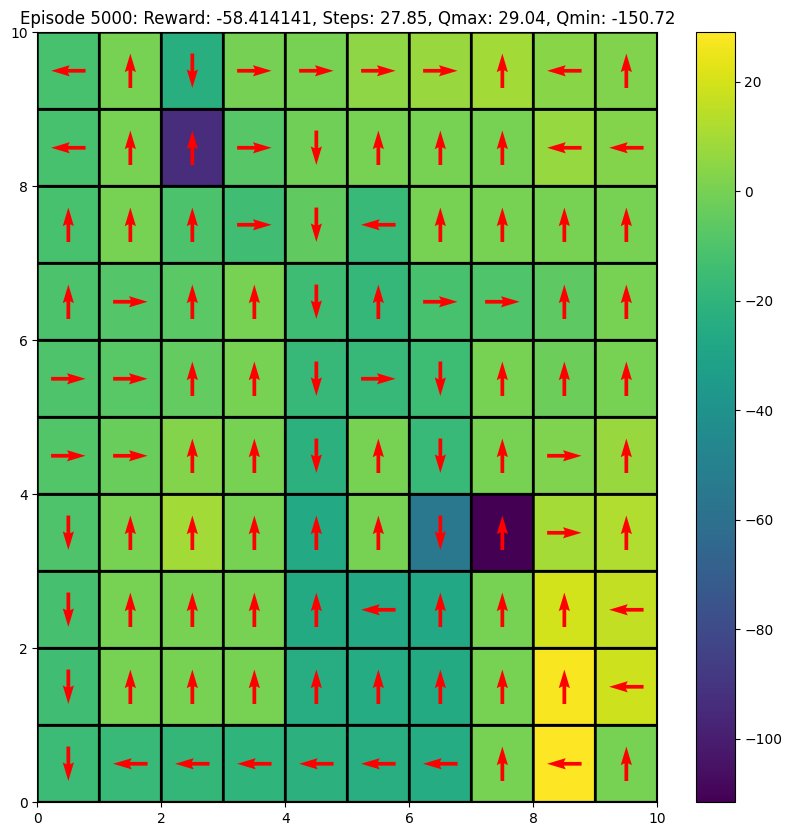

100%|██████████| 5000/5000 [00:34<00:00, 146.62it/s]


In [ ]:
from sklearn.model_selection import ParameterGrid
import itertools

param_grid = {
    'epsilon': [0.08, 0.1,0.12,0.14,0.16, 0.18],
    'alpha': [0.08, 0.1,0.12],
    'gamma': [0.95, 0.97,0.99],
}

param_combinations = list(ParameterGrid(param_grid))

results = []
start_state=[3,6]
for params in param_combinations:
    performance_metric = run_experiment_and_get_metric(env, 'sarsa', start_state, True, params['alpha'], params['gamma'], params['epsilon'],p_good_transition=1.0)

    results.append({
        'params': params,'performance_metric': performance_metric
    })
best_result = max(results, key=lambda x: x['performance_metric'])
best_params = best_result['params']


In [ ]:
print(best_params)

{'alpha': 0.1, 'epsilon': 0.08, 'gamma': 0.99}
